In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output


## Load RAG output files

In [172]:
neo4j_rag = pd.read_csv('../data/results/cypher_rag_output.csv')
kg_rag = pd.read_csv('../data/results/kg_rag_output.csv')



## Token usage comparison

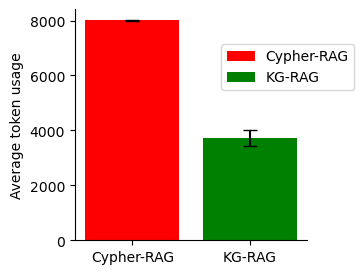

There is 53.3% reduction in token usage for KG-RAG compared to Cypher-RAG


In [173]:
neo4j_rag.loc[:, 'token_usage'] = 0.5*(neo4j_rag.total_tokens_used + neo4j_rag.total_tokens_used_perturbed)
kg_rag.loc[:, 'token_usage'] = 0.5*(kg_rag.total_tokens_used + kg_rag.total_tokens_used_perturbed)

neo4j_avg = neo4j_rag['token_usage'].mean()
neo4j_sem = neo4j_rag['token_usage'].sem()

kg_avg = kg_rag['token_usage'].mean()
kg_sem = kg_rag['token_usage'].sem()


fig = plt.figure(figsize=(3, 3))

plt.bar(0, neo4j_avg, yerr=neo4j_sem, color='red', ecolor='black', capsize=5, label='Cypher-RAG')

plt.bar(1, kg_avg, yerr=kg_sem, color='green', ecolor='black', capsize=5, label='KG-RAG')

plt.ylabel('Average token usage')
plt.xticks([0, 1], ['Cypher-RAG', 'KG-RAG'])

sns.despine()

plt.legend(loc='center left', bbox_to_anchor=(0.6, 0.75))

plt.show()

percentage_of_reduction_in_token_usage = round(100*(neo4j_avg-kg_avg)/neo4j_avg,1)
print(f'There is {percentage_of_reduction_in_token_usage}% reduction in token usage for KG-RAG compared to Cypher-RAG')

fig_path = '../data/results/figures'
os.makedirs(fig_path, exist_ok=True)
fig.savefig(os.path.join(fig_path, 'token_usage_comparison.svg'), format='svg', bbox_inches='tight')      


## Retrieval accuracy comparison

### Cypher-RAG

In [174]:

neo4j_rag_no_nan = neo4j_rag.dropna(subset=['neo4j_rag_answer'])
neo4j_rag_no_nan.loc[:, 'contains_pvalue'] = neo4j_rag_no_nan.apply(lambda row: str(row['gwas_pvalue']) in str(row['neo4j_rag_answer']), axis=1)
neo4j_rag_yes_count_df = neo4j_rag_no_nan[neo4j_rag_no_nan.neo4j_rag_answer.str.contains('Yes')]
neo4j_rag_yes_count = neo4j_rag_yes_count_df.shape[0]
indices_to_remove = neo4j_rag_yes_count_df.index.tolist()
neo4j_rag_no_nan = neo4j_rag_no_nan.drop(indices_to_remove)
neo4j_rag_p_value_correct_retrieval_count = neo4j_rag_no_nan[neo4j_rag_no_nan.contains_pvalue==True].shape[0]
neo4j_rag_total_correct_retrieval = neo4j_rag_yes_count + neo4j_rag_p_value_correct_retrieval_count

kg_rag_no_nan = kg_rag.dropna(subset=['kg_rag_answer'])
kg_rag_yes_count_df = kg_rag_no_nan[kg_rag_no_nan.kg_rag_answer.str.contains('Yes')]
kg_rag_yes_count = kg_rag_yes_count_df.shape[0]
indices_to_remove = kg_rag_yes_count_df.index.tolist()
kg_rag_no_nan = kg_rag_no_nan.drop(indices_to_remove)
kg_rag_no_nan.loc[:, 'contains_pvalue'] = kg_rag_no_nan.apply(lambda row: str(row['gwas_pvalue']) in str(row['kg_rag_answer']), axis=1)
kg_rag_p_value_correct_retrieval_count = kg_rag_no_nan[kg_rag_no_nan.contains_pvalue==True].shape[0]
kg_rag_total_correct_retrieval = kg_rag_yes_count + kg_rag_p_value_correct_retrieval_count

clear_output()

neo4j_rag_total_correct_retrieval_percentage = 100*neo4j_rag_total_correct_retrieval/neo4j_rag.shape[0]
kg_rag_total_correct_retrieval_percentage = 100*kg_rag_total_correct_retrieval/kg_rag.shape[0]

print(f'Correct retrieval percentage for Cypher-RAG {neo4j_rag_total_correct_retrieval_percentage}%')
print(f'Correct retrieval percentage for KG-RAG {kg_rag_total_correct_retrieval_percentage}%')


Correct retrieval percentage for Cypher-RAG 75.0%
Correct retrieval percentage for KG-RAG 97.0%


### KG-RAG

In [175]:

neo4j_rag_no_nan = neo4j_rag.dropna(subset=['neo4j_rag_answer_perturbed'])
neo4j_rag_no_nan.loc[:, 'contains_pvalue'] = neo4j_rag_no_nan.apply(lambda row: str(row['gwas_pvalue']) in str(row['neo4j_rag_answer_perturbed']), axis=1)
neo4j_rag_yes_count_df = neo4j_rag_no_nan[neo4j_rag_no_nan.neo4j_rag_answer_perturbed.str.contains('Yes')]
neo4j_rag_yes_count = neo4j_rag_yes_count_df.shape[0]
indices_to_remove = neo4j_rag_yes_count_df.index.tolist()
neo4j_rag_no_nan = neo4j_rag_no_nan.drop(indices_to_remove)
neo4j_rag_p_value_correct_retrieval_count = neo4j_rag_no_nan[neo4j_rag_no_nan.contains_pvalue==True].shape[0]
neo4j_rag_total_correct_retrieval_perturbed = neo4j_rag_yes_count + neo4j_rag_p_value_correct_retrieval_count

kg_rag_no_nan = kg_rag.dropna(subset=['kg_rag_answer_perturbed'])
kg_rag_yes_count_df = kg_rag_no_nan[kg_rag_no_nan.kg_rag_answer_perturbed.str.contains('Yes')]
kg_rag_yes_count = kg_rag_yes_count_df.shape[0]
indices_to_remove = kg_rag_yes_count_df.index.tolist()
kg_rag_no_nan = kg_rag_no_nan.drop(indices_to_remove)
kg_rag_no_nan.loc[:, 'contains_pvalue'] = kg_rag_no_nan.apply(lambda row: str(row['gwas_pvalue']) in str(row['kg_rag_answer_perturbed']), axis=1)
kg_rag_p_value_correct_retrieval_count = kg_rag_no_nan[kg_rag_no_nan.contains_pvalue==True].shape[0]
kg_rag_total_correct_retrieval_perturbed = kg_rag_yes_count + kg_rag_p_value_correct_retrieval_count

clear_output()

neo4j_rag_total_correct_retrieval_perturbed_percentage = 100*neo4j_rag_total_correct_retrieval_perturbed/neo4j_rag.shape[0]
kg_rag_total_correct_retrieval_perturbed_percentage = 100*kg_rag_total_correct_retrieval_perturbed/kg_rag.shape[0]

print(f'Correct retrieval percentage for Cypher-RAG after name perturbation {neo4j_rag_total_correct_retrieval_perturbed_percentage}%')
print(f'Correct retrieval percentage for KG-RAG after name perturbation {kg_rag_total_correct_retrieval_perturbed_percentage}%')


Correct retrieval percentage for Cypher-RAG after name perturbation 0.0%
Correct retrieval percentage for KG-RAG after name perturbation 97.0%


### Bar plot

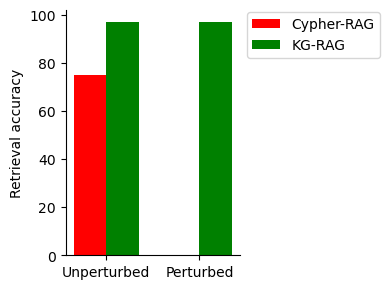

In [176]:

categories = ['Unperturbed', 'Perturbed']
neo4j_rag_percentage = [neo4j_rag_total_correct_retrieval_percentage, neo4j_rag_total_correct_retrieval_perturbed_percentage]
kg_rag_percentage = [kg_rag_total_correct_retrieval_percentage, kg_rag_total_correct_retrieval_perturbed_percentage]

neo4j_color = 'red'
kg_rag_color = 'green'

fig, ax = plt.subplots(figsize=(4, 3))

bar_width = 0.35
index = range(len(categories))

ax.bar(index, neo4j_rag_percentage, bar_width, color=neo4j_color, label='Cypher-RAG')
ax.bar([i + bar_width for i in index], kg_rag_percentage, bar_width, color=kg_rag_color, label='KG-RAG')

ax.set_ylabel('Retrieval accuracy')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(categories)


ax.legend(loc='center left', bbox_to_anchor=(1, 0.9))

sns.despine()

plt.tight_layout()
plt.show()

fig_path = '../data/results/figures'
os.makedirs(fig_path, exist_ok=True)
fig.savefig(os.path.join(fig_path, 'retrieval_accuracy_comparison.svg'), format='svg', bbox_inches='tight')      


In [177]:
neo4j_rag_percentage

[75.0, 0.0]

In [178]:
kg_rag_percentage

[97.0, 97.0]

In [181]:
round(neo4j_avg)

8006

In [182]:
round(kg_avg)

3740